<a href="https://colab.research.google.com/github/Maraudier/tkfruit/blob/CoLab-Testing/GrilloImageSorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [3]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"michaelgrillo","key":"1b1b61b21b7bd669c2b170bf718b9cd8"}
with open ('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [10]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification -p /content

100% 3.58G/3.58G [01:10<00:00, 7.68MB/s]
100% 3.58G/3.58G [01:10<00:00, 54.7MB/s]


In [11]:
!unzip \*.zip

Archive:  fruits-fresh-and-rotten-for-classification.zip
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.15 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.22 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.01.41 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.02.43 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.03.40 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.04.16 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.04.24 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.05.34 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.05.41 PM.png  
  inflating: dataset/dataset/test/freshapples/Screen 

In [0]:
!rm -rf /content/dataset/dataset

In [13]:
!ls

dataset  fruits-fresh-and-rotten-for-classification.zip  sample_data


In [0]:
import pathlib
train_dir=pathlib.Path('dataset/train')
test_dir=pathlib.Path('dataset/test')

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras import datasets, layers, models
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

TensorFlow 2.x selected.


In [16]:
image_count =len(list(train_dir.glob('*/*.png')))+ len(list(test_dir.glob('*/*.png')))
class_names=np.array([item.name for item in train_dir.glob('*') if item.name != 'LICENSE.txt'])
class_names

array(['freshapples', 'freshoranges', 'freshbanana', 'rottenapples',
       'rottenoranges', 'rottenbanana'], dtype='<U13')

In [0]:
test_generator= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
batch_size= 64
img_height= 64
img_width= 64
steps_per_epoch= np.ceil(image_count/batch_size)

In [18]:
train_data_gen = train_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     class_mode="sparse",
                                                     classes = list(class_names))
test_data_gen = test_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     class_mode="sparse",
                                                     classes = list(class_names))


Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [35]:
model=models.Sequential()
model.add(layers.Conv2D(128, (3,3), activation='selu', input_shape=(img_height, img_width, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (1,1), activation='selu'))
model.add(layers.Conv2D(128, (3, 3), activation='selu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (1,1), activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='selu'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 128)       3584      
_________________________________________________________________
batch_normalization_15 (Batc (None, 62, 62, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 31, 31, 64)        8256      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)      

In [0]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history= model.fit_generator(
    train_data_gen,
    epochs=30,
    validation_data=test_data_gen
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 171 steps, validate for 43 steps
Epoch 1/30
171/171 [==============================] - 59s 345ms/step - loss: 2.7143 - accuracy: 0.6931 - val_loss: 3.4315 - val_accuracy: 0.5345
Epoch 2/30
171/171 [==============================] - 58s 339ms/step - loss: 1.1100 - accuracy: 0.7769 - val_loss: 1.2540 - val_accuracy: 0.6920
Epoch 3/30
171/171 [==============================] - 59s 342ms/step - loss: 0.8087 - accuracy: 0.8152 - val_loss: 0.4241 - val_accuracy: 0.8933
Epoch 4/30
171/171 [==============================] - 58s 339ms/step - loss: 0.7226 - accuracy: 0.8395 - val_loss: 0.8861 - val_accuracy: 0.8554
Epoch 5/30
171/171 [==============================] - 58s 340ms/step - loss: 0.5162 - accuracy: 0.8614 - val_loss: 0.4554 - val_accuracy: 0.8784
Epoch 6/30
171/171 [==============================] - 58s 340ms/step - loss: 0.4905 - accuracy: 0.8721 - val_loss: 1.5334 - val_accuracy: 0.8343
Epoch 7/30
171/171 [=================

  ...
    to  
  ['...']
43/43 - 9s - loss: 0.3316 - accuracy: 0.9277


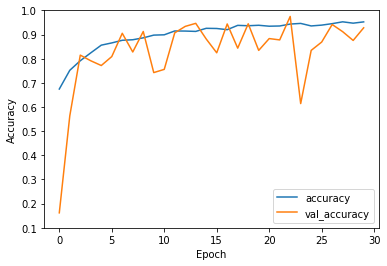

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)
